In [1]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

from sklearn.utils import shuffle

tfds.disable_progress_bar()

2023-03-12 08:12:26.948531: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

2023-03-12 08:12:43.804696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
# data = pd.read_json("datasets/dataset.json")
# data['hasBadWords'] = data.hasBadWords.apply(lambda x: 1 if x == True else 0)
# data.drop(['violation'], axis=1, inplace=True)

# data = shuffle(data)

# df = data[:80000]

# test =  data[80001:]


# dataVar_tensor = tf.constant(data.hasBadWords, dtype = tf.float32, shape=[86439, 1])

# train_dataset = tf.constant(([df['text'], df['hasBadWords']]))

In [5]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


2023-03-12 08:12:44.806877: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'I know that you\'ve already entered this in film festivals (or at least I think you have, I may just be making that up) but I think this should get "best animated short film" in every one. Bravo. I can\'t wait for the full film. I realize that you may not hear this often enough because of the bizarre nature of your animations, but hear it now and accept it as the truth. Kudos, my friend. Okay, now I\'m just trying to get ten lines of text... Though I still mean it. And here comes yet another -SHOE!- and I cannot stop here yet. This is extremely annoying and yet at the same time I have nothing better to do. In fact, I\'ll probably watch all of your movies in yet another spasmodic "Jason Steele Marathon." I do have a lot of those.<br /><br />-R'
 b'This is the first non-zombie subgenre review ive done but this movie is worth doing a review for. Dinocroc is a good movie in general but unfortunately it is still an obvious b-movie. The Dinocroc itself looked great but i thought t

2023-03-12 08:12:45.284460: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [9]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10, 118,  12, ...,   0,   0,   0],
       [ 11,   7,   2, ...,   0,   0,   0],
       [117, 253, 608, ...,   0,   0,   0]])

In [12]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'I know that you\'ve already entered this in film festivals (or at least I think you have, I may just be making that up) but I think this should get "best animated short film" in every one. Bravo. I can\'t wait for the full film. I realize that you may not hear this often enough because of the bizarre nature of your animations, but hear it now and accept it as the truth. Kudos, my friend. Okay, now I\'m just trying to get ten lines of text... Though I still mean it. And here comes yet another -SHOE!- and I cannot stop here yet. This is extremely annoying and yet at the same time I have nothing better to do. In fact, I\'ll probably watch all of your movies in yet another spasmodic "Jason Steele Marathon." I do have a lot of those.<br /><br />-R'
Round-trip:  i know that youve already [UNK] this in film [UNK] or at least i think you have i may just be making that up but i think this should get best [UNK] short film in every one [UNK] i cant wait for the full film i realize th

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 3s 3s/step
[0.02948892]


In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 513s 1s/step - loss: 0.6554 - accuracy: 0.5632 - val_loss: 0.5377 - val_accuracy: 0.7417
Epoch 2/10


2023-03-12 08:21:26.901649: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 574s 1s/step - loss: 0.4261 - accuracy: 0.8064 - val_loss: 0.3735 - val_accuracy: 0.8224
Epoch 3/10


2023-03-12 08:31:01.093329: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 609s 2s/step - loss: 0.3463 - accuracy: 0.8474 - val_loss: 0.3348 - val_accuracy: 0.8542
Epoch 4/10


2023-03-12 08:41:10.392248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 1301s 3s/step - loss: 0.3206 - accuracy: 0.8589 - val_loss: 0.3334 - val_accuracy: 0.8422
Epoch 5/10


2023-03-12 09:02:51.648129: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 1722s 4s/step - loss: 0.3124 - accuracy: 0.8639 - val_loss: 0.3566 - val_accuracy: 0.8594
Epoch 6/10


2023-03-12 09:31:33.970639: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 513s 1s/step - loss: 0.3059 - accuracy: 0.8684 - val_loss: 0.3191 - val_accuracy: 0.8583
Epoch 7/10


2023-03-12 09:40:07.010633: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 528s 1s/step - loss: 0.3010 - accuracy: 0.8703 - val_loss: 0.3230 - val_accuracy: 0.8635
Epoch 8/10


2023-03-12 09:48:55.036863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 697s 2s/step - loss: 0.3016 - accuracy: 0.8692 - val_loss: 0.3417 - val_accuracy: 0.8594
Epoch 9/10


2023-03-12 10:00:32.160441: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 1252s 3s/step - loss: 0.2975 - accuracy: 0.8714 - val_loss: 0.3212 - val_accuracy: 0.8552
Epoch 10/10


2023-03-12 10:21:24.051272: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


391/391 [==============================] - 977s 3s/step - loss: 0.2943 - accuracy: 0.8731 - val_loss: 0.3198 - val_accuracy: 0.8677


2023-03-12 10:37:41.511252: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 251s 641ms/step - loss: 0.3188 - accuracy: 0.8644
Test Loss: 0.31884342432022095
Test Accuracy: 0.8644000291824341


(0.0, 0.673468790948391)

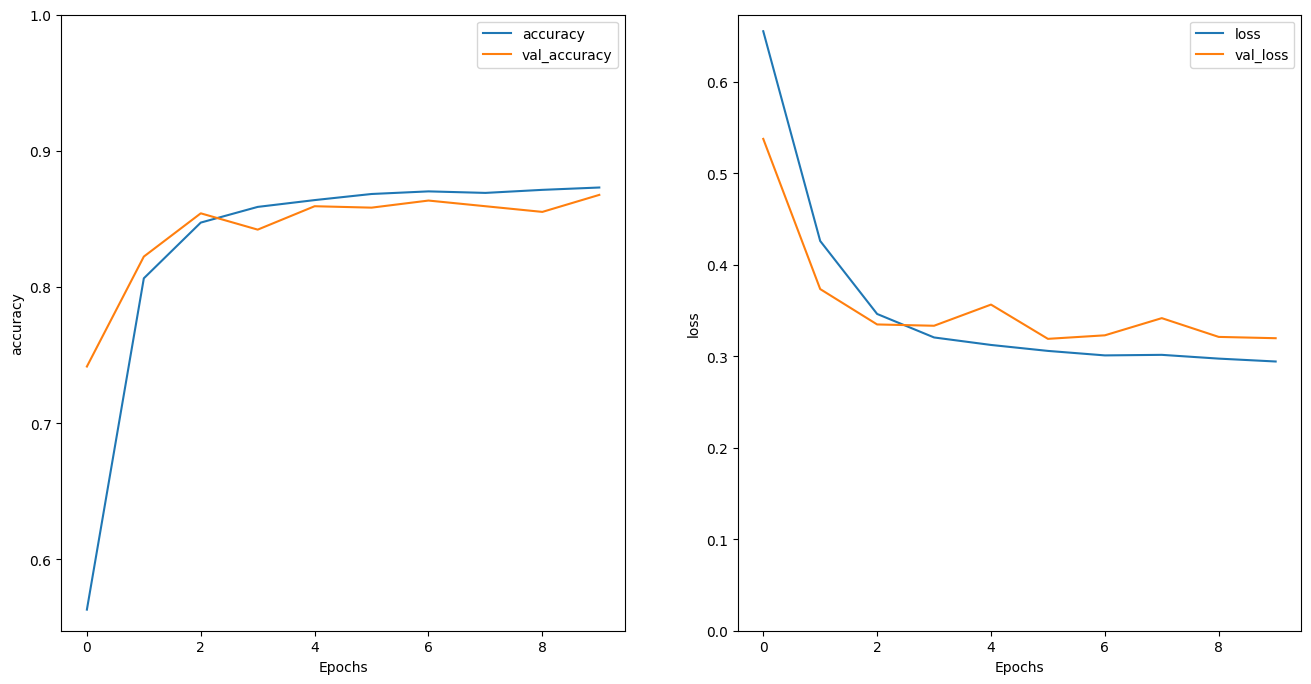

In [19]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [20]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 7s 7s/step


In [21]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [22]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [23]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 2090s 5s/step - loss: 0.6082 - accuracy: 0.6083 - val_loss: 0.4326 - val_accuracy: 0.7932
Epoch 2/10
391/391 [==============================] - 2821s 7s/step - loss: 0.4106 - accuracy: 0.8207 - val_loss: 0.3794 - val_accuracy: 0.8245
Epoch 3/10
391/391 [==============================] - 3880s 10s/step - loss: 0.3521 - accuracy: 0.8502 - val_loss: 0.3493 - val_accuracy: 0.8427
Epoch 4/10
391/391 [==============================] - 5007s 13s/step - loss: 0.3337 - accuracy: 0.8590 - val_loss: 0.3343 - val_accuracy: 0.8484
Epoch 5/10
391/391 [==============================] - 3130s 8s/step - loss: 0.3207 - accuracy: 0.8642 - val_loss: 0.3314 - val_accuracy: 0.8531
Epoch 6/10
391/391 [==============================] - 8216s 21s/step - loss: 0.3119 - accuracy: 0.8664 - val_loss: 0.3265 - val_accuracy: 0.8510
Epoch 7/10
391/391 [==============================] - 2554s 7s/step - loss: 0.3060 - accuracy: 0.8710 - val_loss: 0.3214 - val_accura

In [24]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 633s 2s/step - loss: 0.3149 - accuracy: 0.8626
Test Loss: 0.31491294503211975
Test Accuracy: 0.8626000285148621


In [25]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 19s 19s/step
[[-1.6142669]]


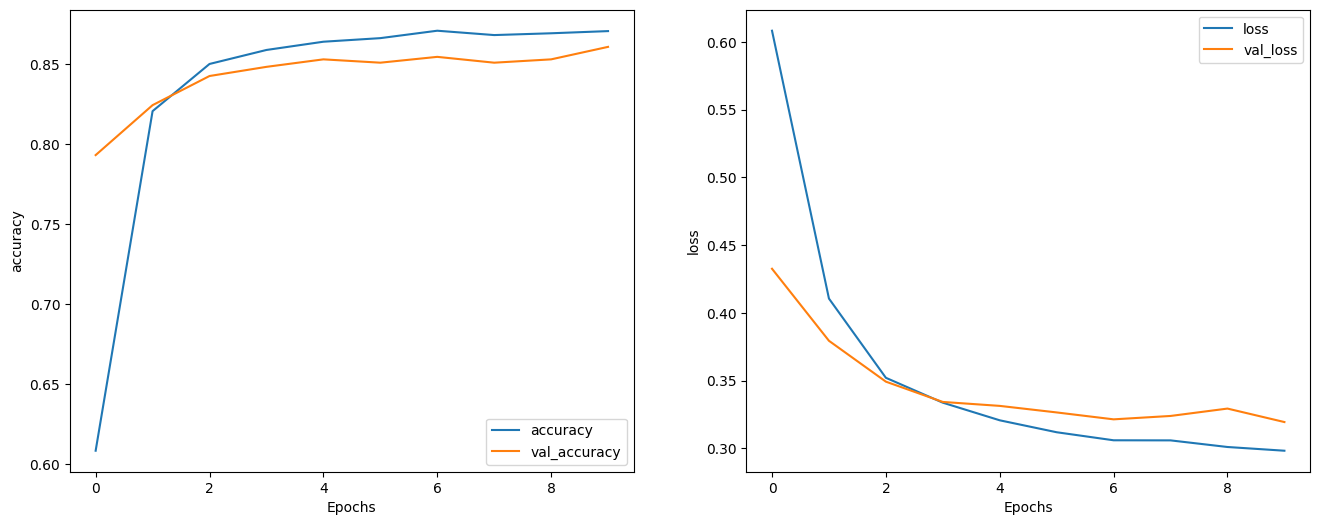

In [26]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')